In [2]:
# Import sys, then tell python where to find the nEXO-specific classes
import sys
sys.path.append('../../../modules')

In [3]:
# Import useful libraries for analysis
import pandas as pd
import hist
from hist import Hist
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path 
import hashlib
import itertools
import glob
import io
from contextlib import redirect_stdout, redirect_stderr

import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [4]:
# Import the nEXO sensitivity classes
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

# Setup

In [5]:
basedir = Path('/p/lustre2/nexouser/samuele/multivarstudy')
outputdir = basedir / 'output'
plotdir = Path('plots')
os.makedirs(plotdir, exist_ok=True)

In [6]:
# import dnn smoothing results obtained from the dnn_smoothing notebook
dnn_factors_df = pd.read_csv('dnn_smoothing_results.csv')
dnn_factors_df = dnn_factors_df.set_index('dnn_f')

# Set default value based on chosen signal efficiency 
signal_efficiency = 80
dnn_factors_df['dnn_cut_value'] = dnn_factors_df[f'dnn_cut_value_{signal_efficiency}']
dnn_factors_df['bkg_misID'] = dnn_factors_df[f'bkg_misID_{signal_efficiency}']

display(dnn_factors_df)

,bkg_misID_85,dnn_cut_value_85,bkg_misID_80,dnn_cut_value_80,bkg_misID_75,dnn_cut_value_75,dnn_cut_value,bkg_misID
dnn_f,,,,,,,,
0.000,7.147604,0.592461,4.265742,0.828392,3.293267,0.885184,0.828392,4.265742
0.150,8.464307,0.562973,6.401218,0.660490,5.445827,0.712378,0.660490,6.401218
0.177,10.101224,0.535913,7.521370,0.622803,6.264636,0.676626,0.622803,7.521370
0.200,12.233255,0.512118,8.926609,0.592769,7.316501,0.647453,0.592769,8.926609


In [6]:
dnn_factors = dnn_factors_df.index
xe137_scale_factors = [1., 1.2, 1.5, 2., ]     # 1., 1.2, 1.5, 2., 3., 
rn222_scale_factors = [1., 1.2, 1.5, 2., ]     # 1., 1.2, 1.5, 2., 3., 
bkg_scale_factors = [1., 1.2, 1.5, 2., ]       # 1., 1.2, 1.5, 2., 3., 
energy_res_factors = [0.008, 0.01, 0.011, 0.012, 0.014]  # 0.008, 0.01, 0.011, 0.012, 0.014

df = pd.DataFrame(columns=['tag', 'dnn_f', 'bkg_misID', 'xe137_f', 'rn222_f', 'bkg_f', 
                           'energy_res_f', 'convergence_f', 
                           'median', 'sens', 'sens_1e28'])
df = df.set_index('tag')
display(df)

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28
tag,,,,,,,,,,


In [7]:
results_file = Path('multivar_study_results.h5')
# delete prior data if needed by uncommenting the following line
# this will result in all data being reloaded which may take some time:
# results_file.unlink()

In [8]:
# load prior data if available
if results_file.is_file():
    df = pd.read_hdf(results_file) 
#     display(df)
# df = df.drop(index=['4A78FC', '1E85A6', 'AD42F2'])
existing_tags = df.index
print(existing_tags)

Index(['381874', '65F25B', '9AB3ED', '93D399', '14784F', 'E2B775', '9277A1',
       '5AA481', '85CFF9', '0E9071', 'E733AD', 'A6EDCF', '54A571', '5E6C53',
       '91C156', '8E1210', '392E34', 'C8BAC8', '99E718', 'DE3D44', '87BCE6',
       '28F17A', 'F6CEBD', 'AF5201', '4C2555', '20D857', '639AE2', '6F5CBC',
       '25356C', '44A209', '9BBE74', '07F17A', 'A6BA89', 'A67FF9', '20E48D',
       'B6F171', 'F1395D', 'E4146C', '0E80EC', '6B31EB', 'FA8BEA', '16D2B8',
       '41C9B5', 'CE144D', '3321A1', '4B37E3', 'C0FEAE', '7BF406', 'B41D83',
       'C56667', '7D927A', 'B9A9CC', '0B7D99', '5C68BF', '50D8DD', 'C91EB8',
       'BE466B', 'FA4545', '63C161', '5C36DF', '619091', '3207DF', 'FDFF8F',
       '0999EA', '09DD31', '7E8B41', '73ED8B', '04478F', '992C89', '332CB6',
       'CE1213', '6899FD', '2461C9', '83BAFF', 'DBF69F', 'E811DA', 'A516CD',
       '1E85A6', '28DD32', '786870', '7DD6E3', '4A78FC', 'EBF57F', 'AD42F2',
       '7A7C15', '800AAD'],
      dtype='object', name='tag')


In [9]:
def get_tag(xe137_scale_factor, rn222_scale_factor, dnn_scale_factor, bkg_scale_factor, energy_res):
    # This should match the hash string used in Compute90PercentLimit script 
    # FIXME: hash should not be calculated both here and Compute90PercentLimit
    s = f'Xe137:{xe137_scale_factor:0>4.4f} ' + \
        f'Rn222:{rn222_scale_factor:0>4.4f} ' + \
        f'DNN:{dnn_scale_factor:0>4.4f} ' + \
        f'Bkg:{bkg_scale_factor:0>4.4f} ' + \
        f'ERes:{energy_res:0>4.4f}'
    return hashlib.md5(s.encode('utf-8')).hexdigest()[:6].upper(), s

In [10]:
def get_expected_counts(df, xe137_scale_factor, rn222_scale_factor, dnn_f, bkg_scale_factor, energy_res_f):
    
    # Note that I use ComponentsTable and Config file that define a much finer binning
    config = '/g/g92/samuele/nEXO/sensitivity/work/SensitivityPaper2020_scripts/' \
             'MultivariationStudy/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1_fineBinning.yaml'
    input_table = basedir / 'ComponentsTables' / f'ComponentsTable_D-024_DNN_factor={dnn_f}_ERes={energy_res_f}_fineBinning.pkl.gz'    
    
    if not input_table.is_file(): 
        return
    
    tag, s = get_tag(xe137_scale_factor, rn222_scale_factor, dnn_f, bkg_scale_factor, energy_res_f)

#     h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
    
#     if h5_files:
    workspace = nEXOFitWorkspace.nEXOFitWorkspace(config)
    workspace.LoadComponentsTableFromFile(input_table)

    for index, row in workspace.df_components.iterrows():
    # Scale the gamma ray background components, except radon
        isotopes_to_leave_alone = ['Ar42', 'Xe137', 'bb2n', 'bb0n', 'B8nu', 'Rn222', ]  # just for bookkeeping
        isotopes_to_scale = ['K40', 'Co60', 'Al26', 'Th232', 'U238', 'Cs137']
        # The format is <isotope>_<part>, e.g. "Th232_HVCables"
        if row['PDFName'].split('_')[0] in isotopes_to_scale:
            print(f'Scaling {row["PDFName"]}...')
            workspace.df_components.loc[index, 'SpecActiv'] = bkg_scale_factor * row['SpecActiv']
            workspace.df_components.loc[index, 'SpecActivErr'] = bkg_scale_factor * row['SpecActivErr']

        # Scale the Xe137 component.
        if 'Xe137' in row['PDFName']:
            workspace.df_components.loc[index, 'SpecActiv'] = xe137_scale_factor * row['SpecActiv']
            workspace.df_components.loc[index, 'SpecActivErr'] = xe137_scale_factor * row['SpecActivErr']

    workspace.CreateGroupedPDFs()

    # Define the ROI within the workspace
    # Note that the ROI energy depends on the resolution since it's +/- FWHM/2
    # The DNN cut is set at the value for 85% signal efficiency
    fwhm = 2457 * energy_res_f * 2.35
    roi_dict = {'DNN': [dnn_factors_df.loc[dnn_f]['dnn_cut_value'], 1.],
                'Energy (keV)': [2457. - fwhm/2., 2457. + fwhm/2.],
                'Standoff (mm)': [104.5, 650.]}
    workspace.DefineROI(roi_dict)
#         print(workspace.df_components.loc[0])

    # Create the likelihood object
    likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs, workspace.histogram_axis_names)

    initial_guess = likelihood.GetVariableValues()

    # Scale the Rn222 component according to the input value
    rn222_idx = likelihood.model.GetVariableIndexByName('Rn222')
    initial_guess[rn222_idx] *= rn222_scale_factor

    # Update the model in the likelihood object
    likelihood.model.UpdateVariables(initial_guess)
    likelihood.model.GenerateModelDistribution()

    # Print out the number of events in the ROI
    df.at[tag, 'TotalROIBkg'] = likelihood.model.GetIntegralInBinRange(workspace.GetROIBinIndices())

    for component in likelihood.model.variable_list:
        if 'Shape' in component['Name']:
            continue
        num_counts_in_roi = likelihood.model.GetComponentIntegralInBinRange(
            component['Name'], workspace.GetROIBinIndices())
        df.at[tag, component['Name']] = num_counts_in_roi
#         print(f'{component["Name"] + ":":<20}\t'
#               f'{num_counts_in_roi:>10.4}\t'
#               f'{int(1000 * num_counts_in_roi / total_bkg_in_roi) / 10.:>10.4}%')

# Load Data

In [11]:
def load_fit_results(tag, s = None):
    h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
    if h5_files:
        print(f'Loading data for tag {tag}')
        if s: print(s)
        df_list = [pd.read_hdf(outputdir/Path(filename)) for filename in h5_files]
        df_tmp = pd.concat(df_list, ignore_index=True)
        print(f'---> Loaded {len(df_tmp)} toy datasets')
        return df_tmp
    return None

In [12]:
dfdict = dict()
for dnn_scale_factor, xe137_scale_factor, rn222_scale_factor, bkg_scale_factor, energy_res \
        in itertools.product(dnn_factors, xe137_scale_factors, rn222_scale_factors, bkg_scale_factors,
                             energy_res_factors):

    tag, s = get_tag(xe137_scale_factor, rn222_scale_factor, dnn_scale_factor, bkg_scale_factor, energy_res)
    
    if tag not in existing_tags: 
    
        res = load_fit_results(tag)

        if res is not None:
            dfdict[tag] = res
            data = {'dnn_f':dnn_scale_factor, 'bkg_misID':dnn_factors_df.loc[dnn_scale_factor]['bkg_misID'],
                    'xe137_f':xe137_scale_factor, 'rn222_f':rn222_scale_factor, 
                    'bkg_f':bkg_scale_factor, 'energy_res_f':energy_res, }
            df.loc[tag] = data
        
    
        if tag in df.index:
            with redirect_stdout(io.StringIO()):    # capture output so it won't pollute the terminal
                with redirect_stderr(io.StringIO()):
                    get_expected_counts(df, xe137_scale_factor, rn222_scale_factor, dnn_scale_factor, bkg_scale_factor, energy_res)  
            print(f"---> Loaded expected counts for {tag}. Total ROI counts: {df.at[tag, 'TotalROIBkg']}")
            print('---------------------------')

#     else:
#         print(f'No data found for tag {tag}')

In [13]:
display(df)

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
381874,0.200,8.757435,2.0,2.0,2.0,0.014,0.993429,10.706071,8142793023724989615376957440.0,0.814279,...,1.339768,0.594963,3.670859,0.278269,13.957388,0.0,0.193861,1.065692,0.000039,0.490561
65F25B,0.177,7.455139,2.0,2.0,2.0,0.014,0.992785,10.311031,8454762300579631934570758144.0,0.845476,...,1.176609,0.487793,2.859832,0.235891,11.680398,0.0,0.193615,1.071298,0.000039,0.479086
9AB3ED,0.200,8.757435,1.5,1.5,1.5,0.014,0.99,10.001,8716859931897600811514986496.0,0.871686,...,1.004826,0.446222,2.753144,0.208702,10.468041,0.0,0.193861,1.065692,0.000039,0.374204
93D399,0.150,6.520094,2.0,2.0,2.0,0.014,0.991571,9.990999,8725585517415015220904984576.0,0.872559,...,1.021384,0.442989,2.415966,0.171769,8.893689,0.0,0.192499,1.065952,0.000038,0.472850
14784F,0.200,8.757435,2.0,2.0,2.0,0.012,0.992727,9.980998,8734328589075751849020096512.0,0.873433,...,1.357047,0.518821,3.482070,0.238410,13.128092,0.0,0.169742,0.469521,0.000039,0.428843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4A78FC,0.000,4.265742,1.0,1.0,1.0,0.011,0.994857,6.850685,12725342966273868465577132032.0,1.272534,...,0.364883,0.121122,0.838221,0.063769,2.918969,0.0,0.153194,0.286172,0.000039,0.194842
EBF57F,0.150,6.520094,1.0,1.0,1.0,0.008,0.9938,6.630663,13147601707236200136604385280.0,1.31476,...,0.460686,0.118879,1.124140,0.070060,4.047525,0.0,0.110718,0.045309,0.000039,0.142788
AD42F2,0.000,4.265742,1.0,1.0,1.0,0.010,0.9942,6.60066,13207363533178183714120663040.0,1.320736,...,0.353158,0.110134,0.829933,0.045366,2.811174,0.0,0.138859,0.164513,0.000039,0.177130


In [14]:
# df_tmp = dfdict['A516CD']
# df_tmp.head()
# print("Number of Toys:", len(df_tmp))

# Compute the convergence fraction

In [15]:
def get_good_fit_mask(df_fit):
    good_fit_mask = []
    for index,row in df_fit.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01\
            or row['best_fit_nll'] > 0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
    return good_fit_mask

In [16]:
good_fit_mask_dict = {}
for tag, df_fit in dfdict.items():
    if tag in existing_tags: continue  # don't process if already exists in dataframe
    good_fit_mask = get_good_fit_mask(df_fit)
    convergence_f = np.sum(good_fit_mask)/len(df_fit)
    print(f'Tag {tag} convergence fraction: {convergence_f:3.3}')
    df.at[tag, 'convergence_f'] = convergence_f
    good_fit_mask_dict[tag] = good_fit_mask

In [17]:
display(df.loc[df['convergence_f']<0.99])

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,


# Compute Median and 90% CL Sensitivity

In [18]:
def calc_atoms_136(enrichment_fraction=0.9):
    """ Number of Xe136 atoms in nEXO fiducial volume """
    mmass134 = 0.133905395  # kg/mol 134
    mmass136 = 0.135907219  # kg/mol 136
    at_frac = enrichment_fraction           # atomic fraction 136 / (136 + 134)
    avog_num = 6.022141E23  # Avogadro's number
    fid_mass = 3281         # mass of fiducial volume [kg]

    atoms136 = (fid_mass * avog_num * at_frac) / ((mmass136 * at_frac) + ((1 - at_frac) * mmass134))

    return atoms136


def ComputeHalflifeFromNumCounts(counts, enrichment_fraction=0.9, lifetime=10):
    """Calculate the sensitivity of nEXO in terms of half-life (years)"""
    atoms136 = calc_atoms_136(enrichment_fraction)
    eff = 0.9598  # hit efficiency
    sensitivity = eff * atoms136 * lifetime * np.log(2) / counts
    return sensitivity


def ComputeCountsFromHalflife(sensitivity, enrichment_fraction=0.9, lifetime=10):
    """Calculate the sensitivity of nEXO in terms of half-life (years)"""
    atoms136 = calc_atoms_136(enrichment_fraction)
    eff = 0.9598  # hit efficiency
    counts = eff * atoms136 * lifetime * np.log(2) / sensitivity
    return counts
    

# def ComputeHalflifeFromNumCounts( counts, enrichment_fraction=0.9 ):
#     '''Returns the half life which would give (on average) the input number of signal counts'''
    
#     N_A = 6.02e23 # atoms/mol
#     FidMass = 3281 # kg
#     AtomicMass = 135.8 # g/mol
#     SigEfficiency = 0.96
#     Livetime = 10 # years
#     return FidMass*1.e3 / AtomicMass * N_A * enrichment_fraction * Livetime * \
#             SigEfficiency * np.log(2) / counts


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Tag	Median [cts]	Sensitivity [y]


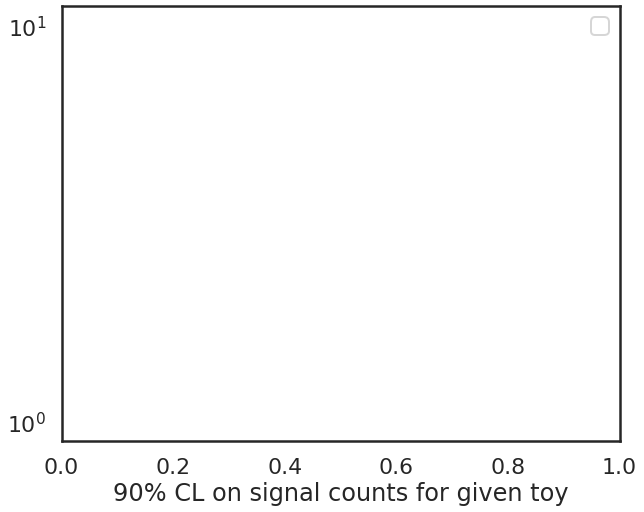

In [19]:
print('Tag\tMedian [cts]\tSensitivity [y]')
fig, ax = plt.subplots()
for tag, df_fit in dfdict.items():
    if tag in existing_tags: continue  # don't process if already exists in dataframe
    h = Hist.new.Regular(121, 0, 60, name="signal_counts").Double()
    values = df_fit['90CL_crossing'].loc[good_fit_mask_dict[tag]]
    h.fill(values)
    median = np.median(values)
    df.at[tag, 'median'] = median
    df.at[tag, 'sens'] = ComputeHalflifeFromNumCounts(median)
    print(f'{tag}\t{median:.3f}\t{df.at[tag, "sens"]:.3e}')
#     print(f'Results for tag {tag}')
#     print(f'   Median 90%CL on signal counts: {median:.3f}')
#     print(f'   Sensitivity: {df.at[tag, "sens"]:.3e} years')

    h.plot1d(ax=ax, label=f'{tag}')

plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')

In [20]:
# format_mapping = {"sens": "{:.3e}", }
# df.style.format(format_mapping)
# df['sens_str'] = df['sens'].apply('{:.3e}'.format)
df['sens_1e28'] = df['sens']/1e28
df = df.sort_values(by=['sens'])

In [21]:
display(df)
df.to_csv('multivar_study_results.csv')
df.to_hdf(results_file, 'df')

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
381874,0.200,8.757435,2.0,2.0,2.0,0.014,0.993429,10.706071,8142793023724989615376957440.0,0.814279,...,1.339768,0.594963,3.670859,0.278269,13.957388,0.0,0.193861,1.065692,0.000039,0.490561
65F25B,0.177,7.455139,2.0,2.0,2.0,0.014,0.992785,10.311031,8454762300579631934570758144.0,0.845476,...,1.176609,0.487793,2.859832,0.235891,11.680398,0.0,0.193615,1.071298,0.000039,0.479086
9AB3ED,0.200,8.757435,1.5,1.5,1.5,0.014,0.99,10.001,8716859931897600811514986496.0,0.871686,...,1.004826,0.446222,2.753144,0.208702,10.468041,0.0,0.193861,1.065692,0.000039,0.374204
93D399,0.150,6.520094,2.0,2.0,2.0,0.014,0.991571,9.990999,8725585517415015220904984576.0,0.872559,...,1.021384,0.442989,2.415966,0.171769,8.893689,0.0,0.192499,1.065952,0.000038,0.472850
14784F,0.200,8.757435,2.0,2.0,2.0,0.012,0.992727,9.980998,8734328589075751849020096512.0,0.873433,...,1.357047,0.518821,3.482070,0.238410,13.128092,0.0,0.169742,0.469521,0.000039,0.428843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4A78FC,0.000,4.265742,1.0,1.0,1.0,0.011,0.994857,6.850685,12725342966273868465577132032.0,1.272534,...,0.364883,0.121122,0.838221,0.063769,2.918969,0.0,0.153194,0.286172,0.000039,0.194842
EBF57F,0.150,6.520094,1.0,1.0,1.0,0.008,0.9938,6.630663,13147601707236200136604385280.0,1.31476,...,0.460686,0.118879,1.124140,0.070060,4.047525,0.0,0.110718,0.045309,0.000039,0.142788
AD42F2,0.000,4.265742,1.0,1.0,1.0,0.010,0.9942,6.60066,13207363533178183714120663040.0,1.320736,...,0.353158,0.110134,0.829933,0.045366,2.811174,0.0,0.138859,0.164513,0.000039,0.177130


/usr/WS1/samuele/nexo_venv/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->Index(['convergence_f', 'median', 'sens', 'sens_1e28'], dtype='object')]

  pytables.to_hdf(


In [22]:
d = df.loc[df['xe137_f']==2.0]
display(d)
df_res_d = {}
for e_res in [0.008, 0.01, 0.012]:
    dd = d.loc[df['energy_res_f'] == e_res]

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
381874,0.200,8.757435,2.0,2.0,2.0,0.014,0.993429,10.706071,8142793023724989615376957440.0,0.814279,...,1.339768,0.594963,3.670859,0.278269,13.957388,0.0,0.193861,1.065692,0.000039,0.490561
65F25B,0.177,7.455139,2.0,2.0,2.0,0.014,0.992785,10.311031,8454762300579631934570758144.0,0.845476,...,1.176609,0.487793,2.859832,0.235891,11.680398,0.0,0.193615,1.071298,0.000039,0.479086
93D399,0.150,6.520094,2.0,2.0,2.0,0.014,0.991571,9.990999,8725585517415015220904984576.0,0.872559,...,1.021384,0.442989,2.415966,0.171769,8.893689,0.0,0.192499,1.065952,0.000038,0.472850
14784F,0.200,8.757435,2.0,2.0,2.0,0.012,0.992727,9.980998,8734328589075751849020096512.0,0.873433,...,1.357047,0.518821,3.482070,0.238410,13.128092,0.0,0.169742,0.469521,0.000039,0.428843
E2B775,0.200,8.757435,2.0,2.0,2.0,0.011,0.993,9.770977,8922067484030297941240446976.0,0.892207,...,1.366011,0.454943,3.571477,0.232361,12.411733,0.0,0.155479,0.284140,0.000039,0.391259
9277A1,0.177,7.455139,2.0,2.0,2.0,0.012,0.993218,9.650965,9033015473469016140020711424.0,0.903302,...,1.075381,0.435035,3.045473,0.226153,10.606942,0.0,0.169613,0.470625,0.000039,0.419214
0E9071,0.200,8.757435,2.0,2.0,2.0,0.010,0.991,9.320932,9352854004181973826663350272.0,0.935285,...,1.395828,0.435051,3.464618,0.221157,12.614468,0.0,0.140755,0.164840,0.000039,0.352319
E733AD,0.177,7.455139,2.0,2.0,2.0,0.011,0.993,9.270927,9403300897408415144555315200.0,0.94033,...,1.184817,0.392183,2.921333,0.183283,10.029909,0.0,0.154717,0.286677,0.000039,0.384277
54A571,0.000,4.265742,2.0,2.0,2.0,0.014,0.990429,9.140914,9537045877349672359559168000.0,0.953705,...,0.701897,0.321210,1.703794,0.144297,5.812121,0.0,0.191465,1.076317,0.000038,0.463059


In [23]:
df.columns

Index(['dnn_f', 'bkg_misID', 'xe137_f', 'rn222_f', 'bkg_f', 'energy_res_f',
       'convergence_f', 'median', 'sens', 'sens_1e28', 'TotalROIBkg',
       'Num_Far', 'Num_Vessel_U238', 'Num_Vessel_Th232', 'Num_Internals_U238',
       'Num_Internals_Th232', 'Num_Rn222', 'Num_FullTPC_K40', 'Num_B8nu',
       'Num_FullLXeBb2n', 'Num_FullLXeBb0n', 'Num_Xe137_and_Ar42'],
      dtype='object')

# Plots grouped by DNN Smearing factor

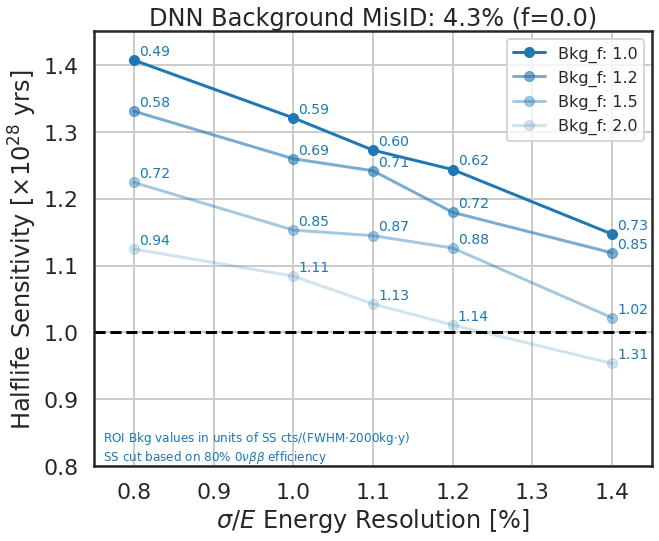

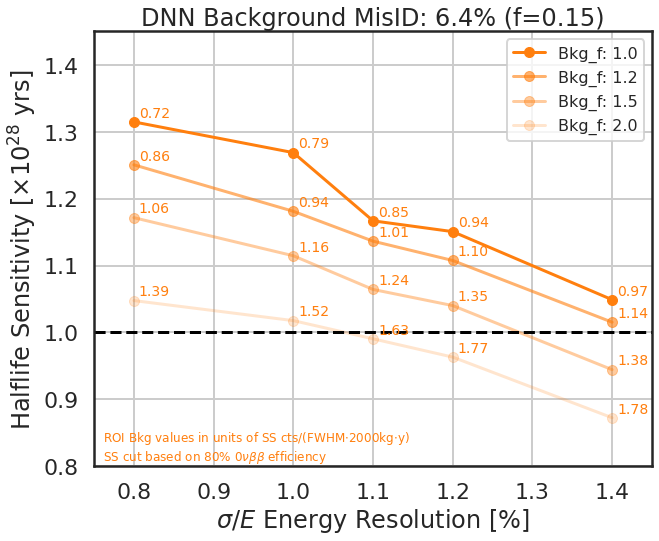

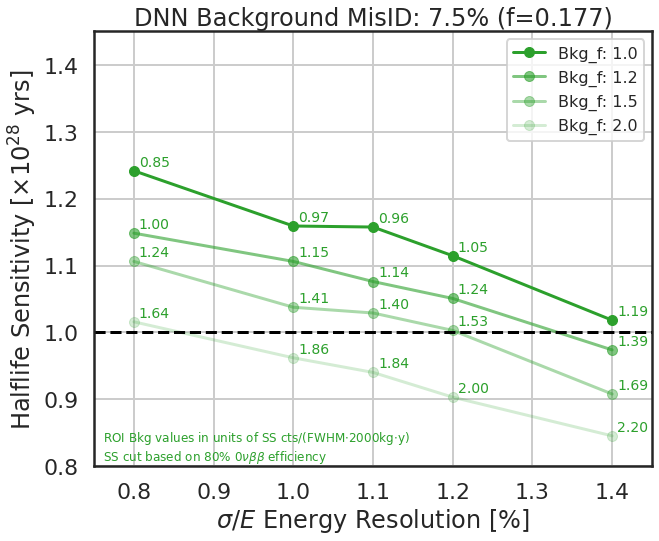

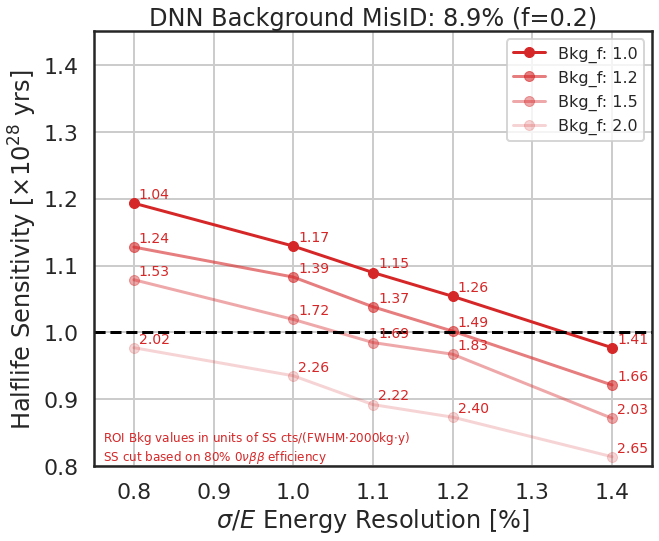

In [24]:
# colors = ['r', 'b', 'g', 'orange']
colors = sns.color_palette('tab10')
alphas = [1.0, 0.6, 0.4, 0.2]
for i, dnn_f in enumerate([0., 0.15, 0.177, 0.2]):
    d = df.loc[(df['dnn_f']==dnn_f) & (df['rn222_f'] == df['bkg_f']) & (df['rn222_f'] == df['xe137_f'])]
    #display(d.sort_values(by=['energy_res_f']))
    for j, bkg_f in enumerate([1.0, 1.2, 1.5, 2.0]):
        dd = d.loc[df['bkg_f'] == bkg_f]
        if not len(dd): continue
#         if bkg_f == 1.5:
#             dt = df.loc[(df['dnn_f']==dnn_f) & (df['rn222_f'] == df['bkg_f']) & (df['xe137_f'] == 1.) & (df['bkg_f'] == bkg_f)]
#             if len(dt):
#                 plt.plot(dt.energy_res_f*100, dt.sens_1e28,'--s', color=colors[i], 
#                      markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f} (no Xe137 scaling)") #DNN_f: {dnn_f}
#                 for (x,y,z) in zip(dt.energy_res_f*100, dt.sens_1e28, dt.TotalROIBkg/10.):
#                     if x == min(dt.energy_res_f)*100:
#                         plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
#                                            color=colors[i], fontsize=14)
        plt.plot(dd.energy_res_f*100, dd.sens_1e28,'-o', color=colors[i], 
                 markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f}") #DNN_f: {dnn_f}
        for (x,y,z) in zip(dd.energy_res_f*100, dd.sens_1e28, dd.TotalROIBkg/10.):
#             if x == min(dd.energy_res_f)*100:
            plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
                                   color=colors[i], fontsize=14)
    
    plt.gca().annotate(r'ROI Bkg values in units of SS cts/(FWHM$\cdot$2000kg$\cdot$y)'
                       + '\n' + fr'SS cut based on {signal_efficiency}% $0\nu\beta\beta$ efficiency', 
                       xy=(9,6), xycoords='axes points', color=colors[i], fontsize=12)       
    plt.xlim((0.75,1.45))    
    plt.ylim((0.8,1.45))    
    plt.title(f"DNN Background MisID: {dnn_factors_df.loc[dnn_f]['bkg_misID']:.1f}% (f={dnn_f})")
    plt.xlabel(r'$\sigma/E$ Energy Resolution [%]')
    plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
    handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
    plt.legend(handles, labels, fontsize=16)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=3,)
    plt.grid()
    plt.savefig(plotdir / f'Multivar_study_by_DNN_{dnn_f}.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
    plt.show()

# Plots grouped by Energy Resolution

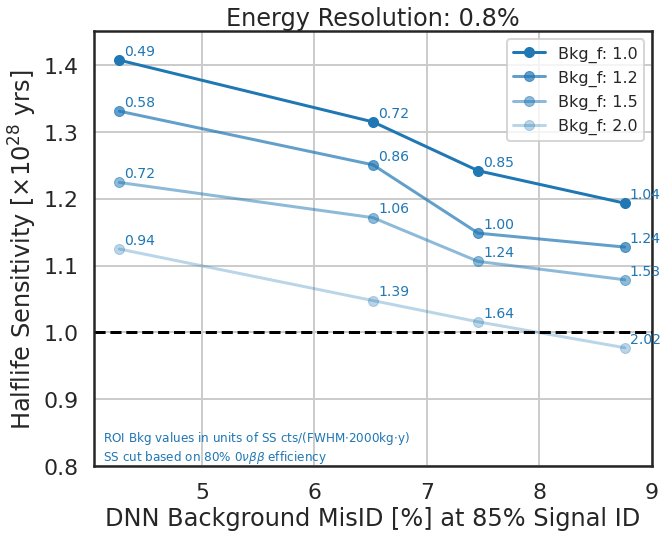

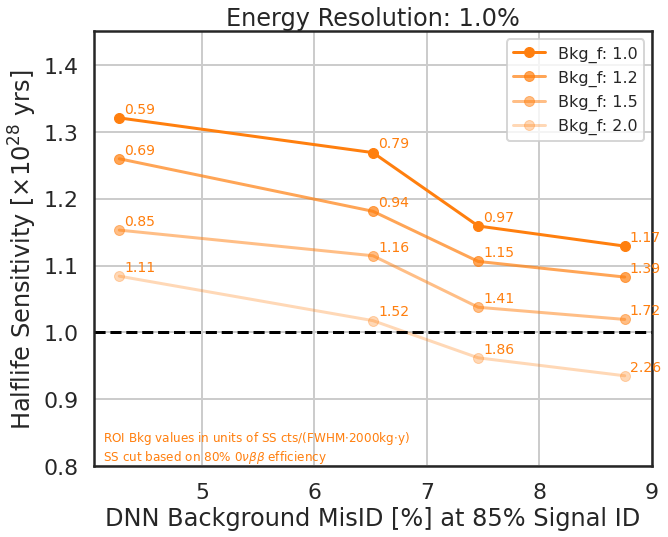

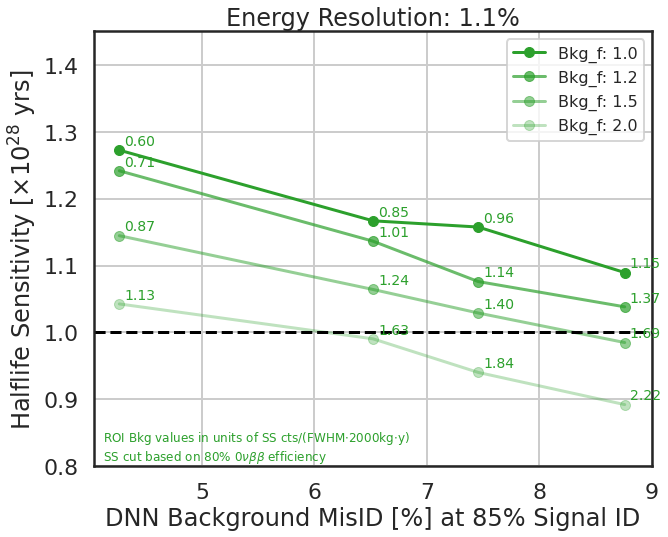

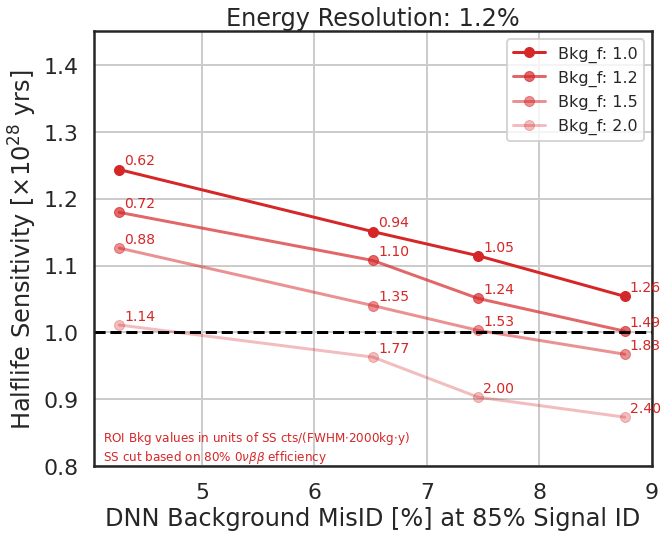

In [25]:
# colors = ['r', 'b', 'g', 'orange']
colors = sns.color_palette('tab10')
alphas = [1.0, 0.7, 0.5, 0.3]
for i, energy_res_f in enumerate([0.008, 0.01, 0.011, 0.012]):
    d = df.loc[(df['energy_res_f']==energy_res_f) & (df['rn222_f'] == df['bkg_f']) & (df['rn222_f'] == df['xe137_f'])]
    #display(d.sort_values(by=['energy_res_f']))
    for j, bkg_f in enumerate([1.0, 1.2, 1.5, 2.0]):
        dd = d.loc[df['bkg_f'] == bkg_f]
        dd = dd.sort_values(by=['bkg_misID'])
        if not len(dd): continue
#         if bkg_f == 1.5:
#             dt = df.loc[(df['energy_res_f']==energy_res_f) & (df['rn222_f'] == df['bkg_f']) & (df['xe137_f'] == 1.) & (df['bkg_f'] == bkg_f)]
#             if len(dt):
#                 plt.plot(dt.bkg_misID, dt.sens_1e28,'--s', color=colors[i], 
#                      markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f} (no Xe137 scaling)") #DNN_f: {dnn_f}
#                 for (x,y,z) in zip(dt.bkg_misID, dt.sens_1e28, dt.TotalROIBkg/10.):
#                     plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
#                                        color=colors[i], fontsize=14)
        plt.plot(dd.bkg_misID, dd.sens_1e28,'-o', color=colors[i], 
                 markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f}") # , ERes: {energy_res_f}
        for (x,y,z) in zip(dd.bkg_misID, dd.sens_1e28, dd.TotalROIBkg/10.):
#             if x == min(dd.bkg_misID):
              plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
                                   color=colors[i], fontsize=14)

    plt.gca().annotate(r'ROI Bkg values in units of SS cts/(FWHM$\cdot$2000kg$\cdot$y)'
                       + '\n' + fr'SS cut based on {signal_efficiency}% $0\nu\beta\beta$ efficiency', 
                       xy=(9,6), xycoords='axes points', color=colors[i], fontsize=12)       
    plt.xlim((None, 9.0))
    plt.ylim((0.8, 1.45))    
    plt.title(f'Energy Resolution: {energy_res_f*100:.1f}%')
    plt.xlabel(r'DNN Background MisID [%] at 85% Signal ID')
    plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
    plt.legend(fontsize=16)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=3,)
    plt.grid()
    plt.savefig(plotdir / f'Multivar_study_by_ERes_{energy_res_f}.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
    plt.show()

# Study convergence 

/tmp/ipykernel_14683/889776137.py:26: RuntimeWarning: divide by zero encountered in true_divide
  counts = eff * atoms136 * lifetime * np.log(2) / sensitivity


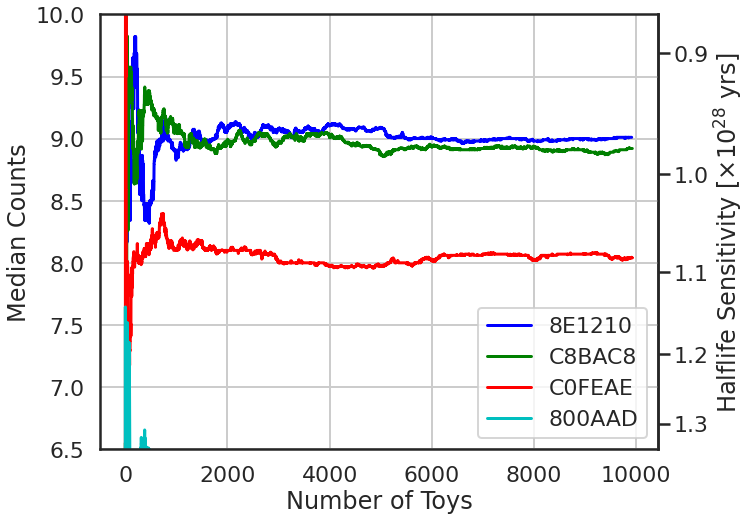

In [26]:
# Given a vector V of length N, the median of V is the middle value 
# of a sorted copy of V, V_sorted - i e., V_sorted[(N-1)/2], when N 
# is odd, and the average of the two middle values of V_sorted when 
# N is even.
# To speed things up, I use `sortedcontainers`
from sortedcontainers import SortedList

for tag in ['8E1210', 'C8BAC8', 'C0FEAE', '800AAD']:
# for tag in df.index:
    
    if tag not in dfdict.keys():
        h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
        if h5_files:
            df_list = [pd.read_hdf(outputdir/Path(filename)) for filename in h5_files]
            dfdict[tag] = pd.concat(df_list, ignore_index=True)
            
    df_fit = dfdict[tag]
    
    good_fit_mask = []
    for index,row in df_fit.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01\
            or row['best_fit_nll'] > 0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)

    values = df_fit['90CL_crossing'].loc[good_fit_mask]

    sl = SortedList()
    medians = []
    for n, v in enumerate(values):
        sl.add(v)
        if v % 2 == 0:  # even
            medians.append(sl[n//2])
        else:  # odd
            medians.append((sl[(n-1)//2] + sl[(n+1)//2]) / 2.)
        if v % 100 == 0:  
            print(medians[-1], ComputeHalflifeFromNumCounts(medians[-1]))

    plt.plot(np.arange(len(values)), medians, '-', linewidth=3, label=tag)
    
plt.xlabel('Number of Toys')
plt.ylabel('Median Counts')
plt.ylim((6.5,10))
plt.legend()
plt.grid()
sec_ax = plt.gca().secondary_yaxis('right', 
                            functions=(lambda x: ComputeHalflifeFromNumCounts(x)/1e28, ComputeCountsFromHalflife))
sec_ax.set_ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
plt.savefig(plotdir / f'Multivar_study_convergence.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
plt.show()


In [35]:
display(df[(df.energy_res_f==0.008) & (df.bkg_f==1.0)])
display(df[(df.dnn_f==0.15) & (df.bkg_f==1.5)])
for tag in df[(df.dnn_f==0.0) & (df.bkg_f==1.0)].index:
    print(df.loc[tag][['energy_res_f','TotalROIBkg']])

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42,TotalROIBkgY,ROIbkg
tag,,,,,,,,,,,,,,,,,,,,,
83BAFF,0.200,8.757435,1.0,1.0,1.0,0.008,0.9932,7.305731,11932730912933060972229165056.0,1.193273,...,1.664595,0.098019,5.910583,0.0,0.111525,0.044763,0.000039,0.148023,1.041550,0.052630
A516CD,0.177,7.455139,1.0,1.0,1.0,0.008,0.993714,7.020702,12417179390167522717741350912.0,1.241718,...,1.276058,0.075544,4.879132,0.0,0.111266,0.045281,0.000039,0.145038,0.846021,0.046743
EBF57F,0.150,6.520094,1.0,1.0,1.0,0.008,0.9938,6.630663,13147601707236200136604385280.0,1.31476,...,1.124140,0.070060,4.047525,0.0,0.110718,0.045309,0.000039,0.142788,0.722472,0.044245
800AAD,0.000,4.265742,1.0,1.0,1.0,0.008,0.9932,6.19562,14070798921545763006609096704.0,1.40708,...,0.759335,0.047357,2.605381,0.0,0.110061,0.045500,0.000039,0.140077,0.492716,0.038488


,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42,TotalROIBkgY,ROIbkg
tag,,,,,,,,,,,,,,,,,,,,,
A6EDCF,0.15,6.520094,1.5,1.5,1.5,0.014,0.992714,9.230923,9444051930549946747344388096.0,0.944405,...,1.811974,0.128827,6.670267,0.0,0.192499,1.065952,0.000038,0.360807,1.378879,0.101437
20E48D,0.15,6.520094,1.5,1.5,1.5,0.012,0.9912,8.380838,10401980825653460612742643712.0,1.040198,...,1.849094,0.138786,6.660114,0.0,0.168461,0.471212,0.000039,0.315421,1.353101,0.089606
16D2B8,0.15,6.520094,1.0,1.5,1.5,0.012,0.9936,8.230823,10591567353460026930637045760.0,1.059157,...,1.849094,0.138786,6.660114,0.0,0.168461,0.471212,0.000039,0.217478,1.343307,0.079811
41C9B5,0.15,6.520094,1.5,1.5,1.5,0.011,0.994,8.190819,10643296620143590586774978560.0,1.06433,...,1.740410,0.133082,6.956683,0.0,0.154084,0.286527,0.000039,0.289279,1.239133,0.082971
0B7D99,0.15,6.520094,1.5,1.5,1.5,0.010,0.993,7.820782,11146879708308952433144365056.0,1.114688,...,1.831949,0.116082,6.390333,0.0,0.139522,0.164990,0.000039,0.260237,1.158677,0.074903
5C36DF,0.15,6.520094,1.0,1.5,1.5,0.010,0.9926,7.710771,11305914308557199142459277312.0,1.130591,...,1.831949,0.116082,6.390333,0.0,0.139522,0.164990,0.000039,0.179454,1.150598,0.066825
332CB6,0.15,6.520094,1.5,1.5,1.5,0.008,0.993,7.440744,11716209585883872862431870976.0,1.171621,...,1.686210,0.105090,6.071287,0.0,0.110718,0.045309,0.000039,0.207103,1.058420,0.060123
2461C9,0.15,6.520094,1.0,1.5,1.5,0.008,0.9944,7.320732,11908278595488526335666552832.0,1.190828,...,1.686210,0.105090,6.071287,0.0,0.110718,0.045309,0.000039,0.142788,1.051989,0.053691


energy_res_f       0.014
TotalROIBkg     7.311508
Name: FDFF8F, dtype: object
energy_res_f       0.012
TotalROIBkg     6.161049
Name: 1E85A6, dtype: object
energy_res_f       0.011
TotalROIBkg     6.014313
Name: 4A78FC, dtype: object
energy_res_f        0.01
TotalROIBkg     5.852398
Name: AD42F2, dtype: object
energy_res_f      0.008
TotalROIBkg     4.92716
Name: 800AAD, dtype: object


Loading data for tag 7BF406
---> Loaded 7000 toy datasets
Loading data for tag 73ED8B
---> Loaded 7000 toy datasets
Loading data for tag 992C89
---> Loaded 7000 toy datasets
Loading data for tag 4A78FC
---> Loaded 7000 toy datasets


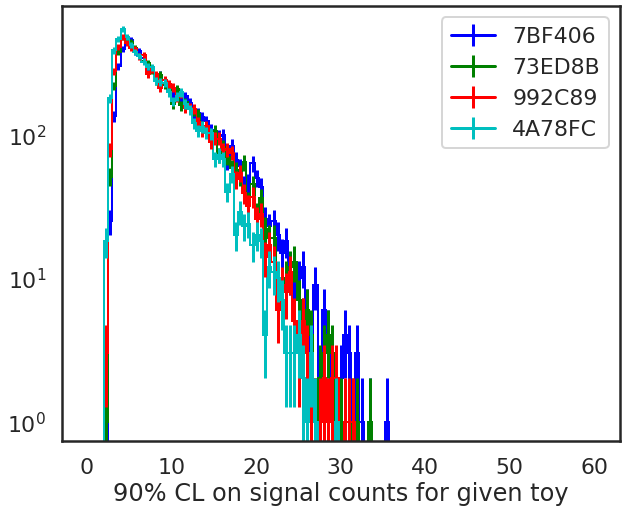

In [28]:
fig, ax = plt.subplots()
for tag in df[(df.energy_res_f==0.011) & (df.bkg_f==1.0)].index:
# for tag in ['992C89', ]:
    df_fit = load_fit_results(tag)
    good_fit_mask = get_good_fit_mask(df_fit)
    h = Hist.new.Regular(121, 0, 60, name="signal_counts").Double()
    values = df_fit['90CL_crossing'].loc[good_fit_mask]
    h.fill(values)
#     median = np.median(values)
#     df.at[tag, 'median'] = median
#     df.at[tag, 'sens'] = ComputeHalflifeFromNumCounts(median)
#     print(f'{tag}\t{median:.3f}\t{df.at[tag, "sens"]:.3e}')
    h.plot1d(ax=ax, label=f'{tag}')

plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')

# Sensitivity as a function of background

In [29]:
df['TotalROIBkgY'] = df['TotalROIBkg']/10.

from scipy.optimize import curve_fit
def f(x, A, exponent):
    return A * x ** (-exponent)

xnew = np.linspace(0.4,3.1,1000)

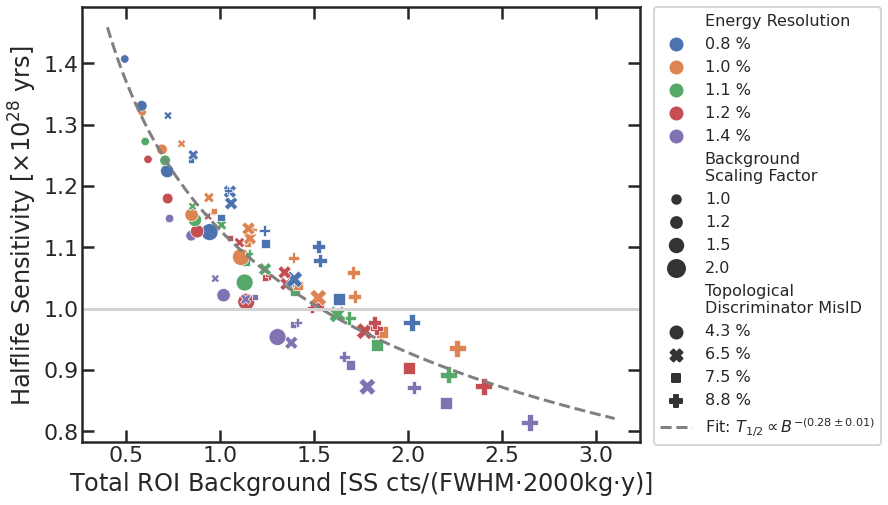

In [34]:
popt, pcov = curve_fit(f, df.TotalROIBkgY, df.sens_1e28)
perr = np.sqrt(np.diag(pcov))
# print(popt, perr)

sns.scatterplot(data=df, x='TotalROIBkgY', y='sens_1e28', hue='energy_res_f', 
                    palette='deep', style='bkg_misID', size='bkg_f', alpha=1 )

plt.plot(xnew, f(xnew, popt[0], popt[1]), '--', color='gray', 
         label=u'Fit: $T_{1/2} \propto B^{'+ f'-({popt[1]:.2f} \pm {perr[1]:.2f})' + '}$')
# Draw uncertainty band
# plt.fill_between(xnew, f(xnew, *(popt))*0.95, f(xnew, *(popt))*1.05, color='gray', alpha=0.2, label = '_nolegend_')
# plt.fill_between(xnew, f(xnew, *(popt+perr)), f(xnew, *(popt-perr)), color='gray', alpha=0.2, label = '_nolegend_')
# plt.fill_between(xnew, f(xnew, popt[0]+perr[0], popt[1]-perr[1]), f(xnew, popt[0]-perr[0], popt[1]+perr[1]), color='gray', alpha=0.2, label = '_nolegend_')

plt.axhline(y=1.0, color='lightgray', linestyle='-', linewidth=3,)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
for k, label in enumerate(labels):
    if k in np.arange(1,6):
        new_labels.append(f'{float(label)*100:.1f} %')
    elif k in np.arange(12,16):
        new_labels.append(f'{float(label):.1f} %')
    else:
        new_labels.append(label)
new_labels[0] = "Energy Resolution"
new_labels[6] = "Background\nScaling Factor"
new_labels[11] = "Topological\nDiscriminator MisID"
plt.legend(handles, new_labels, bbox_to_anchor=(1.01,1.02), loc="upper left", fontsize=16)

plt.xlabel('Total ROI Background [SS cts/(FWHM$\cdot$2000kg$\cdot$y)]')
plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
plt.tick_params(axis='both', which='major', direction='in', reset=True)

plt.savefig(plotdir / f'Sensivitity_vs_background.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
plt.show()

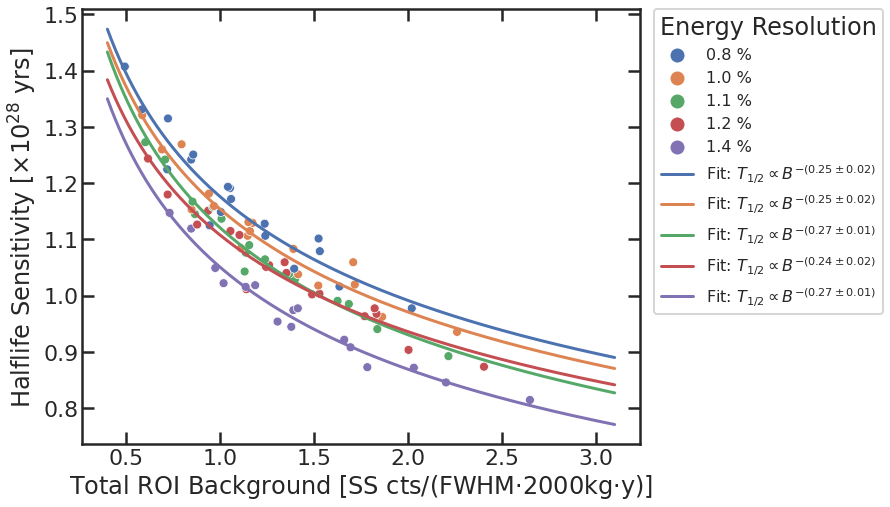

In [31]:
# Grouped and fitted by energy resolution
sns.scatterplot(data=df, x='TotalROIBkgY', y='sens_1e28', hue='energy_res_f', palette='deep', s=80 )

colors = iter(sns.color_palette('deep'))
for e_res in [0.008, 0.01, 0.011, 0.012, 0.014]:
    dtemp = df[df['energy_res_f']==e_res]
    popt, pcov = curve_fit(f, dtemp.TotalROIBkgY, dtemp.sens_1e28)
    perr = np.sqrt(np.diag(pcov))

    plt.plot(xnew, f(xnew, popt[0], popt[1]), '-', color=next(colors), 
             label=u'Fit: $T_{1/2} \propto B^{'+ f'-({popt[1]:.2f} \pm {perr[1]:.2f})' + '}$')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
for label in labels:
    if label.replace('.', '', 1).isdigit():
        new_labels.append(f'{float(label)*100:.1f} %')
    else:
        new_labels.append(label)
plt.legend(handles, new_labels, title="Energy Resolution", bbox_to_anchor=(1.01,1.02), loc="upper left", fontsize=16)

plt.xlabel('Total ROI Background [SS cts/(FWHM$\cdot$2000kg$\cdot$y)]')
plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
plt.tick_params(axis='both', which='major', direction='in', reset=True)

plt.savefig(plotdir / f'Sensivitity_vs_background_groupByERes.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
plt.show()

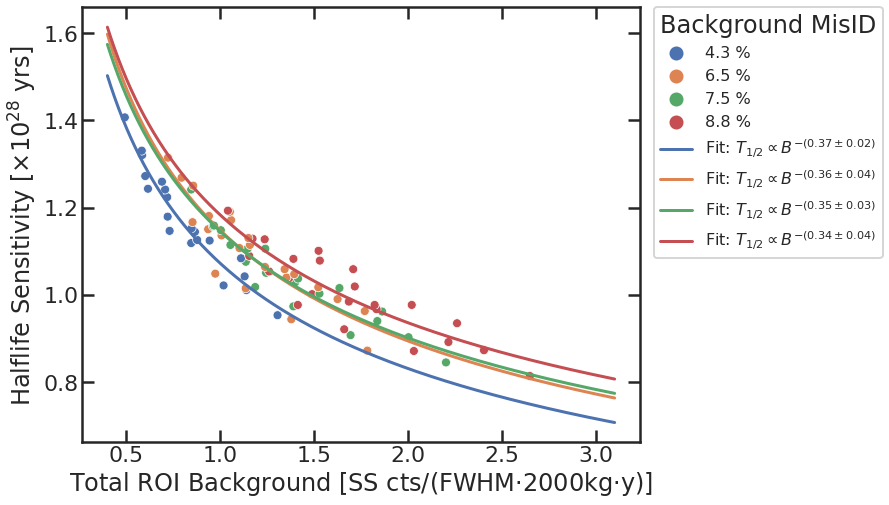

In [32]:
sns.scatterplot(data=df, x='TotalROIBkgY', y='sens_1e28', hue='bkg_misID', palette='deep', s=80)

colors = iter(sns.color_palette('deep'))
for dnn_f in [0., 0.15, 0.177, 0.2]:
    dtemp = df[df['dnn_f']==dnn_f]
    popt, pcov = curve_fit(f, dtemp.TotalROIBkgY, dtemp.sens_1e28)
    perr = np.sqrt(np.diag(pcov))
    # print(popt, perr)

    plt.plot(xnew, f(xnew, popt[0], popt[1]), '-', color=next(colors), 
             label=u'Fit: $T_{1/2} \propto B^{'+ f'-({popt[1]:.2f} \pm {perr[1]:.2f})' + '}$')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
for label in labels:
    if label.replace('.', '', 1).isdigit():
        new_labels.append(f'{float(label):.1f} %')
    else:
        new_labels.append(label)
plt.legend(handles, new_labels, title="Background MisID", bbox_to_anchor=(1.01,1.02), loc="upper left", fontsize=16)

plt.xlabel('Total ROI Background [SS cts/(FWHM$\cdot$2000kg$\cdot$y)]')
plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
plt.tick_params(axis='both', which='major', direction='in', reset=True)

plt.savefig(plotdir / f'Sensivitity_vs_background_groupDNNF.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
plt.show()

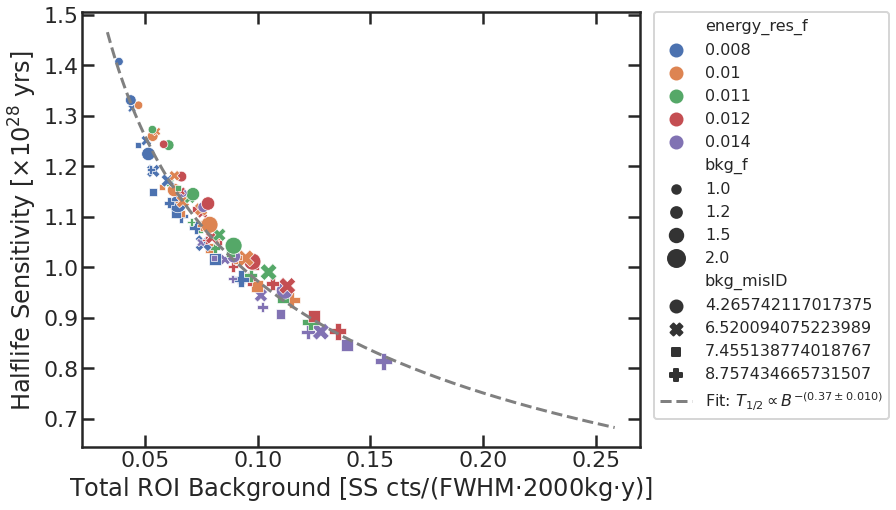

In [33]:
# df['ROIbkg'] = 0.1 * (df['Num_Vessel_U238'] + df['Num_Internals_U238'] + df['Num_Rn222'] + df['Num_Far'])
df['ROIbkg'] = 0.1 * (df['Num_Vessel_Th232'] + df['Num_Internals_Th232'] + df['Num_B8nu'] + df['Num_Xe137_and_Ar42'])
 
popt, pcov = curve_fit(f, df.ROIbkg, df.sens_1e28)
perr = np.sqrt(np.diag(pcov))
# print(popt, perr)

# sns.scatterplot(data=df, x='TotalROIBkgYkeV', y='sens_1e28', hue='bkg_misID', 
#                 palette='deep', style='energy_res_f', size='bkg_f', alpha=1 )

sns.scatterplot(data=df, x='ROIbkg', y='sens_1e28', hue='energy_res_f', 
                    palette='deep', style='bkg_misID', size='bkg_f', alpha=1 )

# xnew = np.linspace(0.4,3.1,1000)
plt.plot(xnew/12, f(xnew/12, popt[0], popt[1]), '--', color='gray', 
         label=u'Fit: $T_{1/2} \propto B^{'+ f'-({popt[1]:.2f} \pm {perr[1]:.3f})' + '}$')
# Draw uncertainty band
# plt.fill_between(xnew/12, f(xnew/12, *(popt)*0.95), f(xnew/12, *(popt)*1.05), color='gray', alpha=0.2, label = '_nolegend_')
# plt.fill_between(xnew/15, f(xnew/15, *(popt+perr)), f(xnew/15, *(popt-perr)), color='gray', alpha=0.2, label = '_nolegend_')
# plt.fill_between(xnew/15, f(xnew/15, popt[0]+perr[0], popt[1]-perr[1]), f(xnew/15, popt[0]-perr[0], popt[1]+perr[1]), color='gray', alpha=0.2, label = '_nolegend_')

# plt.axhline(y=1.0, color='lightgray', linestyle='-', linewidth=3,)

handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = []
# for k, label in enumerate(labels):
#     if k in np.arange(1,5):
#         new_labels.append(f'{float(label)*100:.1f} %')
#     elif k in np.arange(12,16):
#         new_labels.append(f'{float(label):.1f} %')
#     else:
#         new_labels.append(label)
# new_labels[0] = "Energy Resolution"
# new_labels[6] = "Background\nScaling Factor"
# new_labels[11] = "Topological\nDiscriminator MisID"
plt.legend(handles, labels, bbox_to_anchor=(1.01,1.02), loc="upper left", fontsize=16)

plt.xlabel('Total ROI Background [SS cts/(FWHM$\cdot$2000kg$\cdot$y)]')
plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
plt.tick_params(axis='both', which='major', direction='in', reset=True)

# plt.savefig(plotdir / f'Sensivitity_vs_background-mod.png', bbox_inches = "tight", 
#                 transparent=False, facecolor='white', dpi=200)
plt.show()